In [1]:
import torch
import sys
import os
sys.path.append('../vega/')
import vega
import scanpy as sc
import numpy as np
import pandas as pd
torch.manual_seed(0)
np.random.seed(0)
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
path_to_save = '../paper/figures/mixseq_vega/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
font = {'family' : 'Arial',
        'size'   : 14}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
# Scanpy figures params
sc.set_figure_params(dpi_save=300)
sc.settings.figdir = path_to_save

### Trametinib example

In [2]:
model = vega.VEGA.load('../trained_models/mixseq/vega_Trametinib_DMSO_24hr_expt3/')
print(model)

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
VEGA model with the following parameters: 
n_GMVs: 55, dropout_rate:0.5, z_dropout:0.5, beta:0.0001, positive_decoder:True
Model is trained: True


In [3]:
model.adata.obsm['X_vega'] = model.to_latent(return_mean=True)
sc.tl.tsne(model.adata, use_rep='X_vega')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


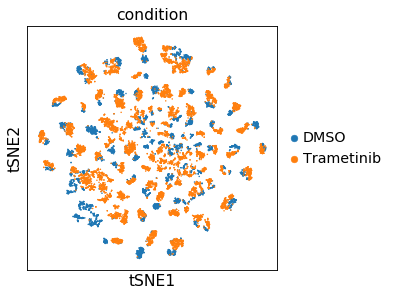

In [4]:
sc.pl.tsne(model.adata, color='condition')
#sc.pl.tsne(model.adata, color='singlet_ID')

In [5]:
tsne_coord = model.adata.obsm['X_tsne']
tsne_df = pd.DataFrame(data=tsne_coord, columns=['tSNE-1', 'tSNE-2'])
tsne_df['Condition'] = model.adata.obs['condition'].values
pathway_encoded_df = pd.DataFrame(model.adata.obsm['X_vega'], columns=model.adata.uns['_vega']['gmv_names'])
train_data = model.adata

In [6]:
# Arrow version
list_arrow = []
cl_name = []
for cl in train_data.obs['singlet_ID'].unique():
    cl_name.append(cl)
    mask_dmso = (train_data.obs['singlet_ID'] == cl) & (train_data.obs['condition'] == 'DMSO')
    mask_tram = (train_data.obs['singlet_ID'] == cl) & (train_data.obs['condition'] == 'Trametinib')
    median_dmso = np.median(tsne_coord[mask_dmso,:], axis=0)
    median_tram = np.median(tsne_coord[mask_tram,:], axis=0)
    d = median_tram - median_dmso
    list_arrow.append((median_dmso[0], median_dmso[1], d[0], d[1]))

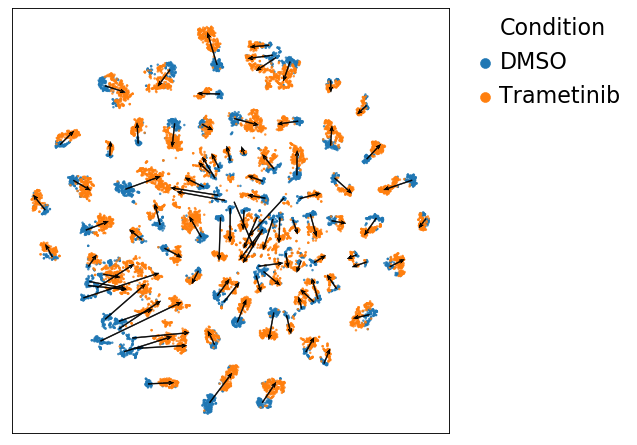

In [8]:
fig, ax = plt.subplots(figsize=[7,7])
sns.scatterplot(x='tSNE-1', y='tSNE-2', hue='Condition',
                data=tsne_df, linewidth=0, alpha=0.8, s=5, ax=ax, rasterized=True)
for a in list_arrow:
    ax.arrow(a[0],a[1],a[2],a[3], width=0.5, head_width=2, overhang=0.6, color='k', alpha=1)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig(path_to_save+'tsne_tram_cond.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

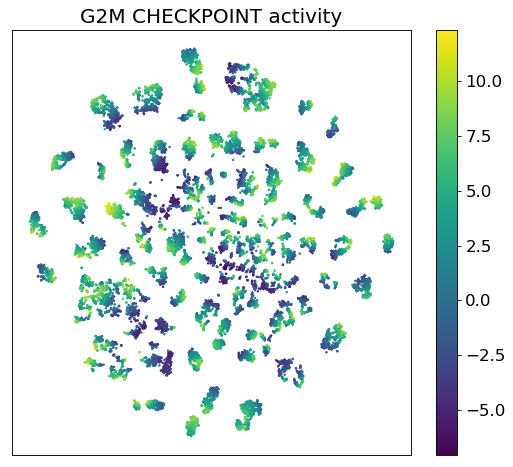

In [12]:
fig, ax = plt.subplots(figsize=[8,7])
sct = ax.scatter(tsne_df['tSNE-1'], tsne_df['tSNE-2'], alpha = 1, linewidths=0,
            c = pathway_encoded_df['HALLMARK_G2M_CHECKPOINT'], marker='o', s=5, cmap = 'viridis', rasterized=True)
cbar = fig.colorbar(sct, ax=ax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
ax.set_title('G2M CHECKPOINT activity', fontsize=18)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig(path_to_save+'tsne_tram_g2m.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Other drugs

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.


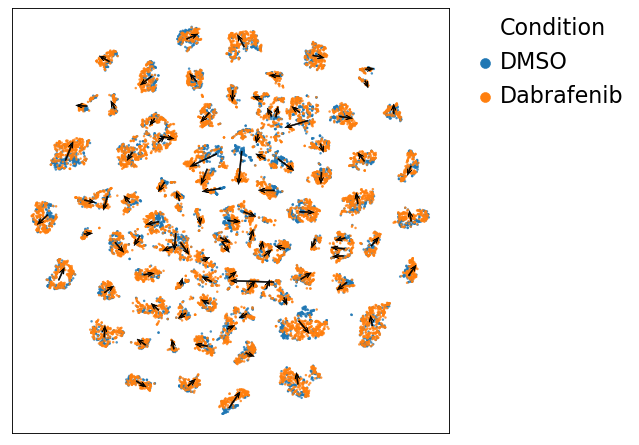

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.


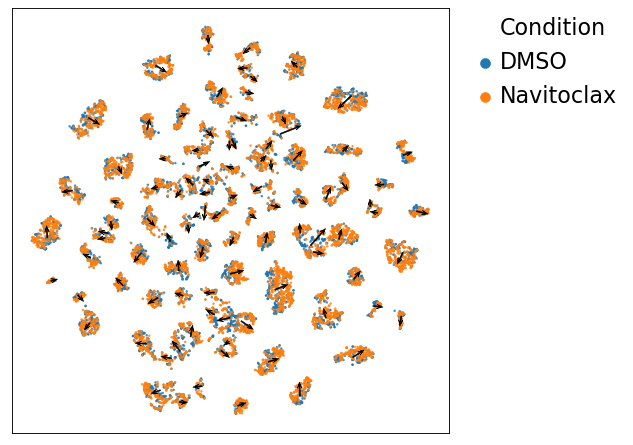

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.


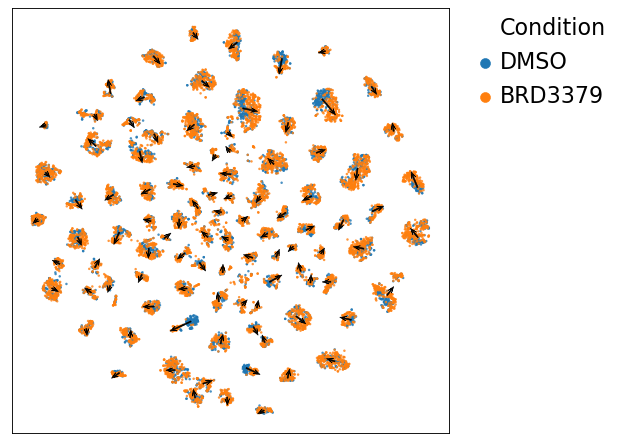

In [13]:
drug_list = ['Dabrafenib', 'Navitoclax', 'BRD3379']
l_tsne_df = []
arrow_dict = {}
for drug in drug_list:
    np.random.seed(0)
    torch.manual_seed(0)
    vae = vega.VEGA.load('../trained_models/mixseq/vega_'+drug+'_DMSO_24hr_expt3/')
    pathway_list = vae.adata.uns['_vega']['gmv_names']
    z = vae.to_latent(return_mean=True)
    vae.adata.obsm['X_vega'] = z
    pathway_encoded_df = pd.DataFrame(data=z, index=vae.adata.obs.index.tolist(), columns=pathway_list)
    tsne_coord = TSNE(n_components=2, random_state=42).fit_transform(z)
    tsne_df = pd.DataFrame({'tSNE-1':tsne_coord[:,0], 'tSNE-2':tsne_coord[:,1],
                            'Cell Line':vae.adata.obs['singlet_ID'], 'Condition':vae.adata.obs['condition']})
    #tsne_df.to_csv('../paper/'+drug+'_tsne_coord.csv', index=True, header=True)
    l_tsne_df.append(tsne_df)
    # Arrow version
    list_arrow = []
    cl_name = []
    for cl in train_data.obs['singlet_ID'].unique():
        cl_name.append(cl)
        mask_dmso = (vae.adata.obs['singlet_ID'] == cl) & (vae.adata.obs['condition'] == 'DMSO')
        mask_tram = (vae.adata.obs['singlet_ID'] == cl) & (vae.adata.obs['condition'] == drug)
        median_dmso = np.median(tsne_coord[mask_dmso,:], axis=0)
        median_tram = np.median(tsne_coord[mask_tram,:], axis=0)
        d = median_tram - median_dmso
        list_arrow.append((median_dmso[0], median_dmso[1], d[0], d[1]))
    # to dict
    arrow_dict[drug] = list_arrow
    fig, ax = plt.subplots(figsize=[7,7])
    sns.scatterplot(x='tSNE-1', y='tSNE-2', hue='Condition',
                    data=tsne_df, linewidth=0, alpha=0.8, s=5, ax=ax, rasterized=True)
    for a in list_arrow:
        ax.arrow(a[0],a[1],a[2],a[3], width=0.5, head_width=2, overhang=0.6, color='k', alpha=1)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=1.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.savefig(path_to_save+'tsne_%s_cond.pdf'%(drug), format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    

# Pickle arrows
# with open('../paper/tsne_arrows.pkl', 'wb') as f:
#     pickle.dump(arrow_dict, f)


### Analysis of Bayes Factor

In [15]:
df_res_all = pd.DataFrame(index=pathway_list)
np.random.seed(4)
model_dirname = '../trained_models/mixseq/'
list_res = os.listdir(model_dirname)
# Iterate over different datasets
for model in list_res:
    # Get dataset name, load, and get best fold for 10CV
    drug_name = model.split('_')[1]
    print('Analysis for '+drug_name)
    vae = vega.VEGA.load(model_dirname+model)
    # Loop over cell lines
    for cell_line in vae.adata.obs['singlet_ID'].unique():
        data_cl = vae.adata[vae.adata.obs['singlet_ID']==cell_line,:].copy()
        vae.differential_activity(adata=data_cl,
                                  groupby='condition',
                                  group1=drug_name,
                                  group2='DMSO',
                                  n_samples=5000,
                                  use_permutations=True,
                                  n_permutations=10000, random_seed=0)
        # Store in df for later
        df_res_all[cell_line+'/'+drug_name] = data_cl.uns['_vega']['differential'][drug_name+' vs.DMSO']['bayes_factor']

Analysis for Dabrafenib
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Analysis for Navitoclax
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Analysis for BRD3379
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Analysis for Trametinib
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.


In [16]:
# Remove Unannotated and HALLMARKS_
df_res_all = df_res_all.iloc[:-5]
df_res_all.index = ['_'.join(i.split('_')[1:]) for i in df_res_all.index.tolist()]

In [17]:
# Extract cell line features
cl_feat = pd.read_csv('../data/mixseq/Trametinib_24hr_expt3_CL_features.csv', sep=',')

In [18]:
from scipy.spatial import distance
import scipy.cluster.hierarchy as sch
# retrieve clusters using fcluster 
d = sch.distance.pdist(df_res_all.T, metric='correlation')
L = sch.linkage(d, method='complete')
clusters = sch.fcluster(L, 0.5*d.max(), 'distance')

In [51]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5

<Figure size 1000x500 with 0 Axes>

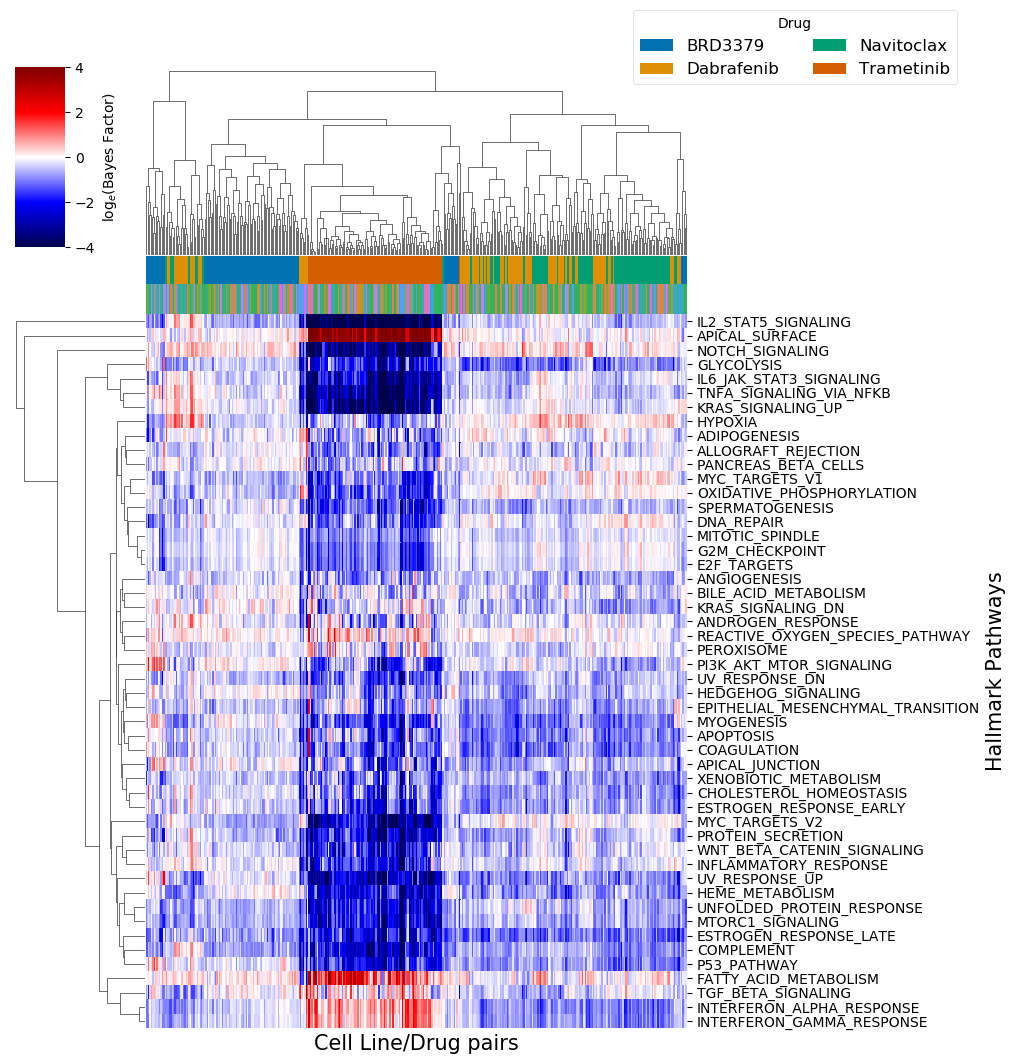

In [53]:
# COlor drug and tissue
drug_lbl = np.array([f.split('/')[1] for f in list(df_res_all)])
lut1 = dict(zip(np.unique(drug_lbl), sns.color_palette("colorblind",len(set(drug_lbl)))))
drug_colors = [lut1[k.split('/')[1]] for k in list(df_res_all)]

cell_lbl = np.array([f.split('/')[0] for f in list(df_res_all)])
lut2 = dict(zip(np.unique(cell_lbl), sns.color_palette("Spectral", len(set(cell_lbl)))))
cell_colors = [lut2[k.split('/')[0]] for k in list(df_res_all)]

tissue_lbl = np.array(['_'.join(f.split('/')[0].split('_')[1:]) for f in list(df_res_all)])
lut3 = dict(zip(np.unique(tissue_lbl), sns.color_palette("husl", len(set(tissue_lbl)))))
tissue_colors = [lut3['_'.join(k.split('/')[0].split('_')[1:])] for k in list(df_res_all)]

plt.figure(figsize=[10,5])
#sns.clustermap(df_res_all, cmap='seismic', col_colors=[drug_colors, cell_colors], center=0)
cg = sns.clustermap(df_res_all, col_linkage=L, cmap='seismic', col_colors=[drug_colors, tissue_colors], center=0, vmin=-4, vmax=4,
                   linewidths=0, xticklabels=False, yticklabels=True,
                   cbar_kws={'label': r'$\log_e$(Bayes Factor)'})


cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_ymajorticklabels(), fontsize = 10)
for label in np.unique(drug_lbl):
    cg.ax_row_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)

l2 = cg.ax_row_dendrogram.legend(title='Drug', loc="center", ncol=2, bbox_to_anchor=(0.8,1),
                                 bbox_transform=plt.gcf().transFigure, fontsize=12)


ax = cg.ax_heatmap
ax.set_xlabel('Cell Line/Drug pairs', fontsize=15)
ax.set_ylabel('Hallmark Pathways', fontsize=15)
plt.savefig(path_to_save+'hm_all_drugs.pdf', format='pdf', dpi=300, bbox_inches='tight')

==== DRUG:Trametinib ===


<Figure size 1000x500 with 0 Axes>

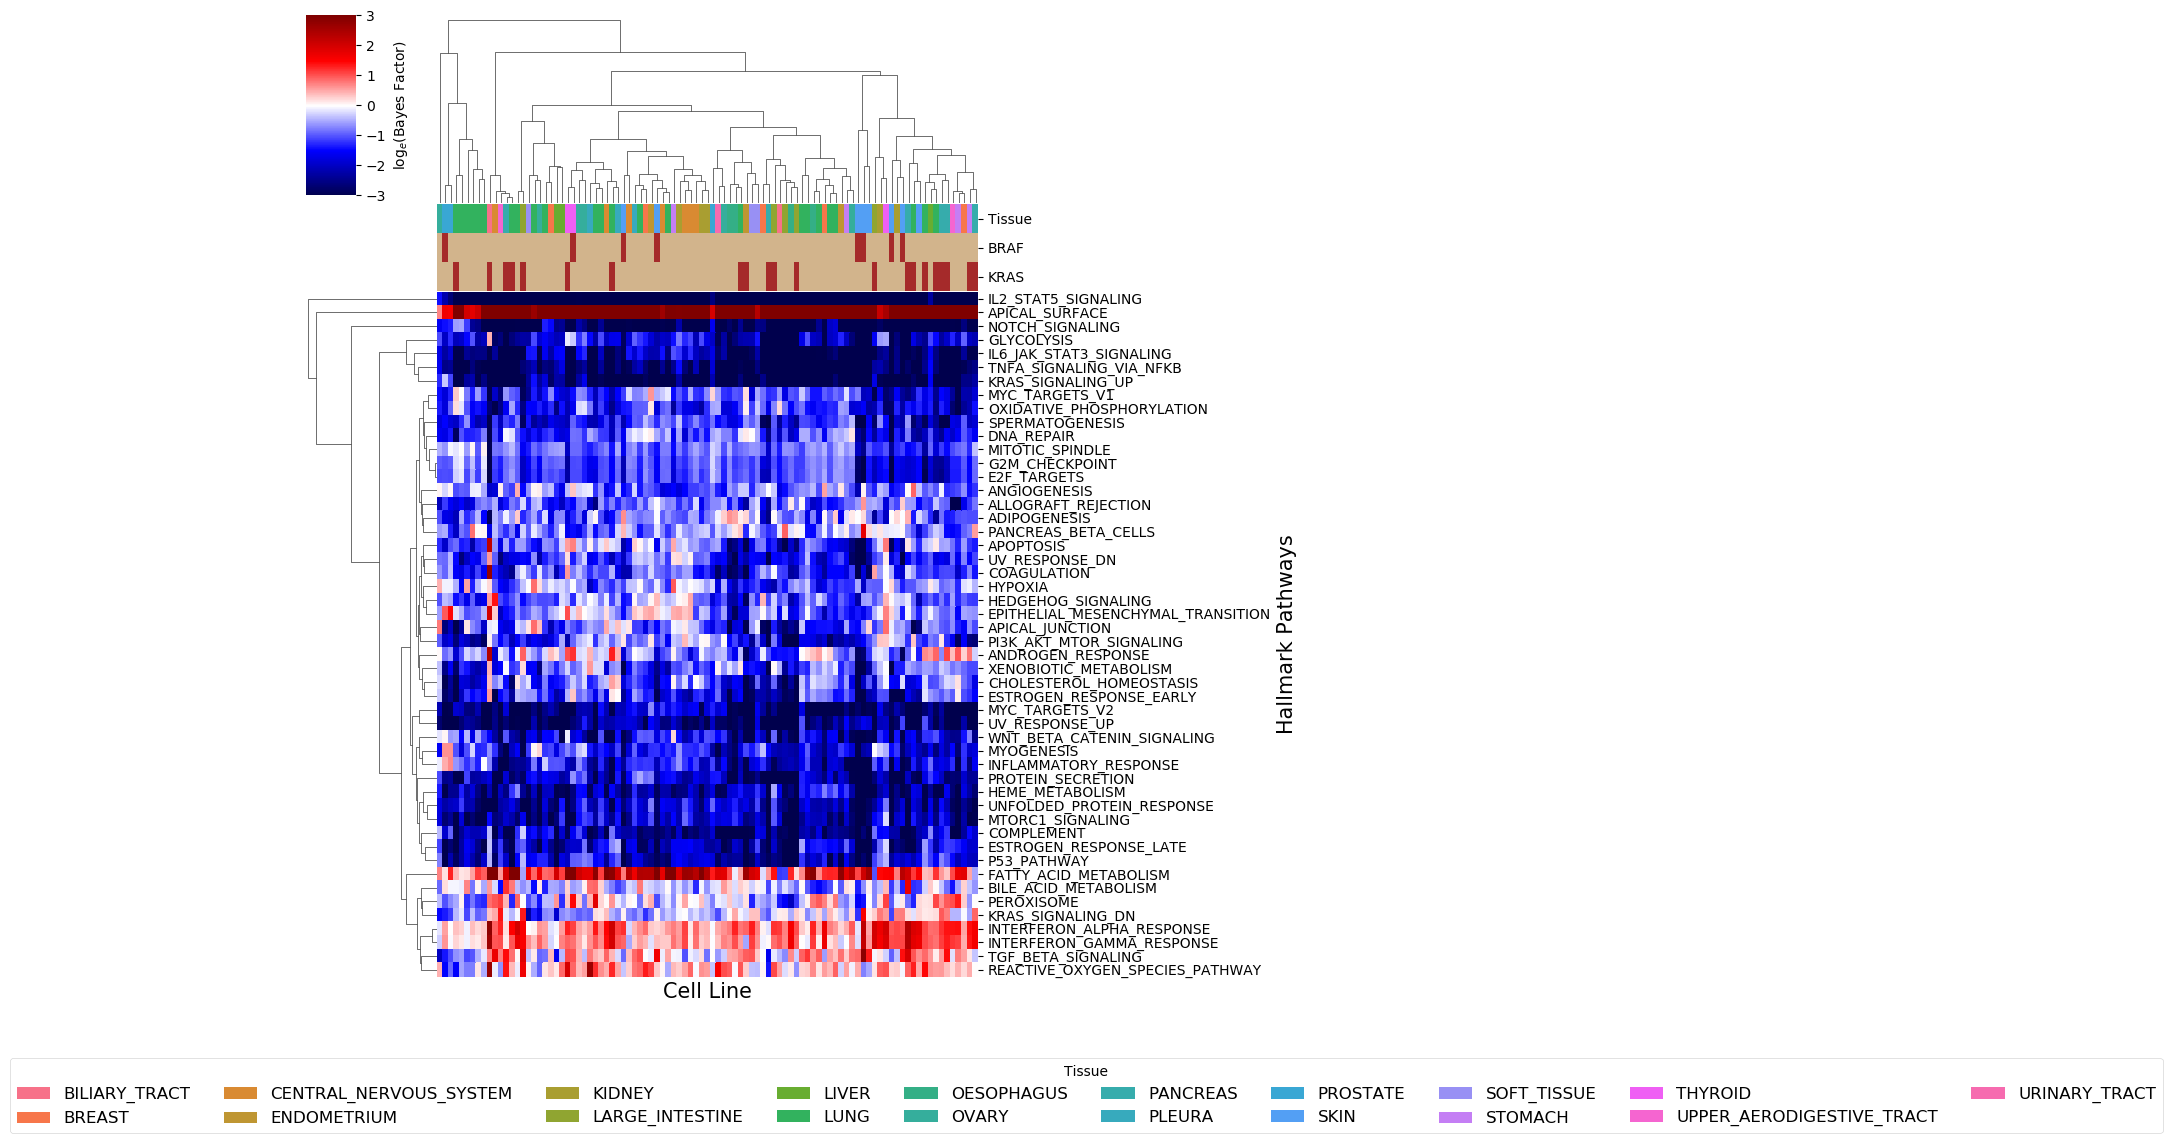

==== DRUG:Dabrafenib ===


<Figure size 1000x500 with 0 Axes>

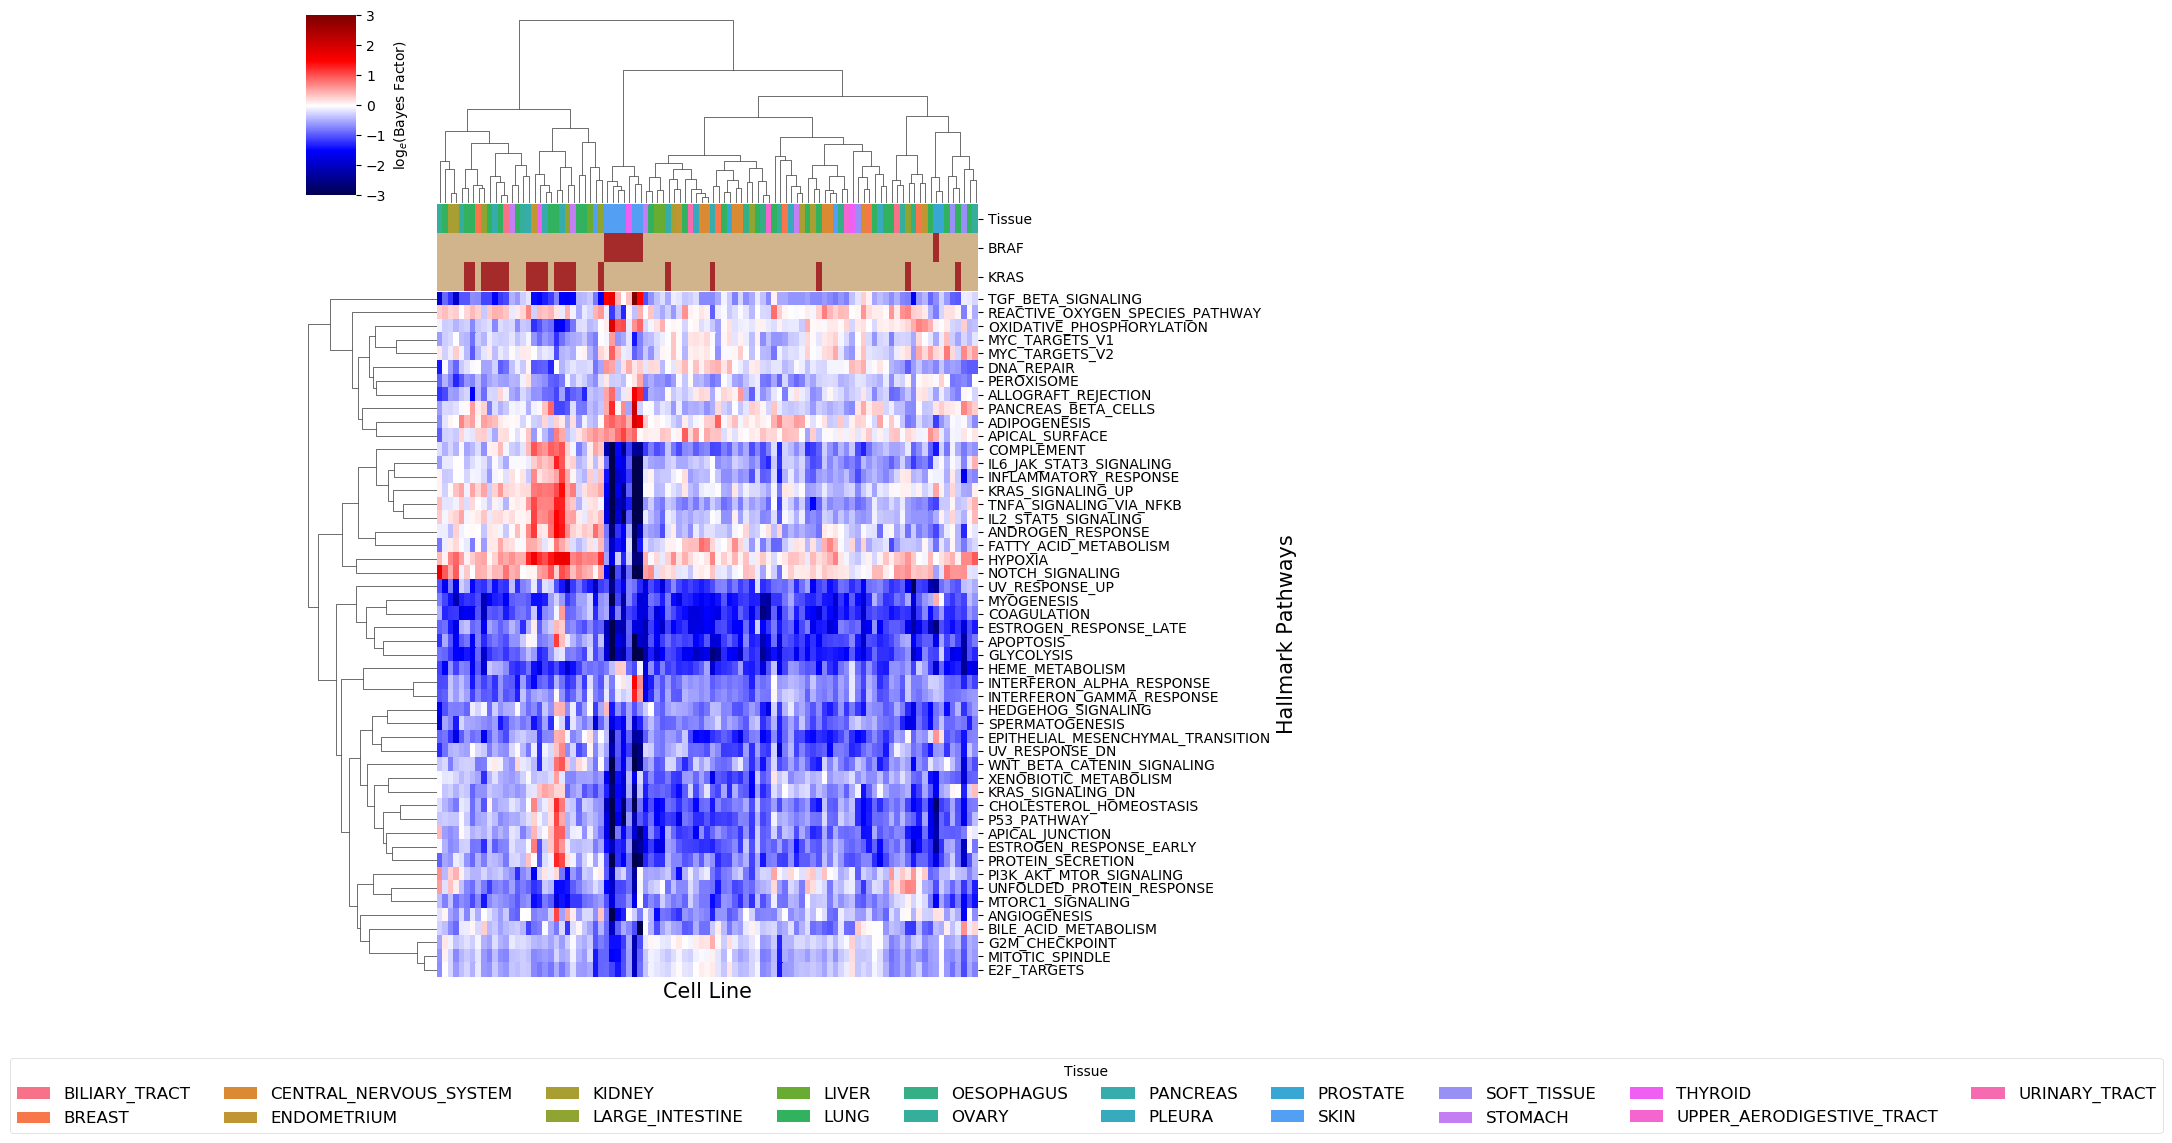

==== DRUG:Navitoclax ===


<Figure size 1000x500 with 0 Axes>

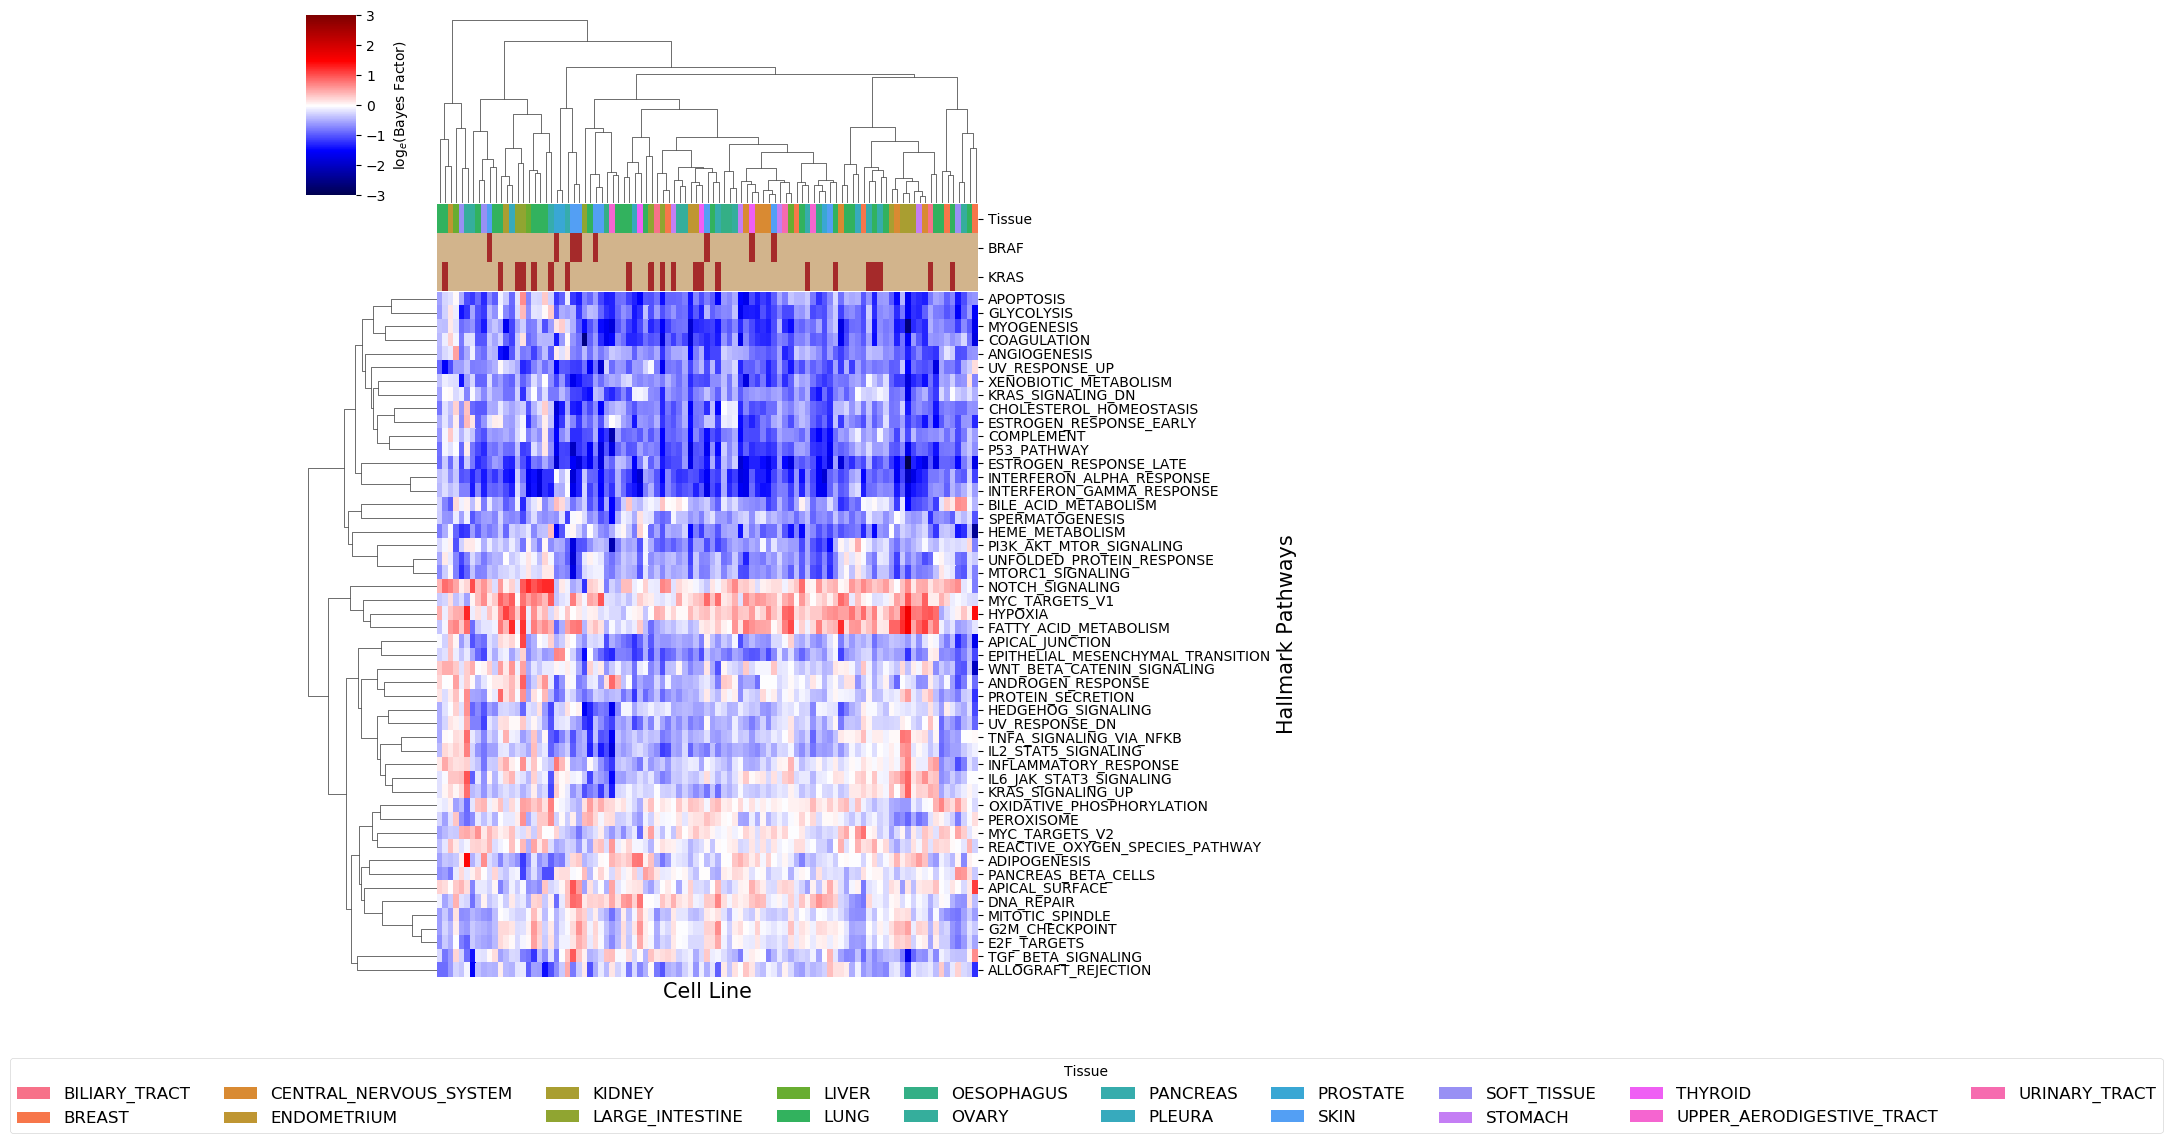

==== DRUG:BRD3379 ===


<Figure size 1000x500 with 0 Axes>

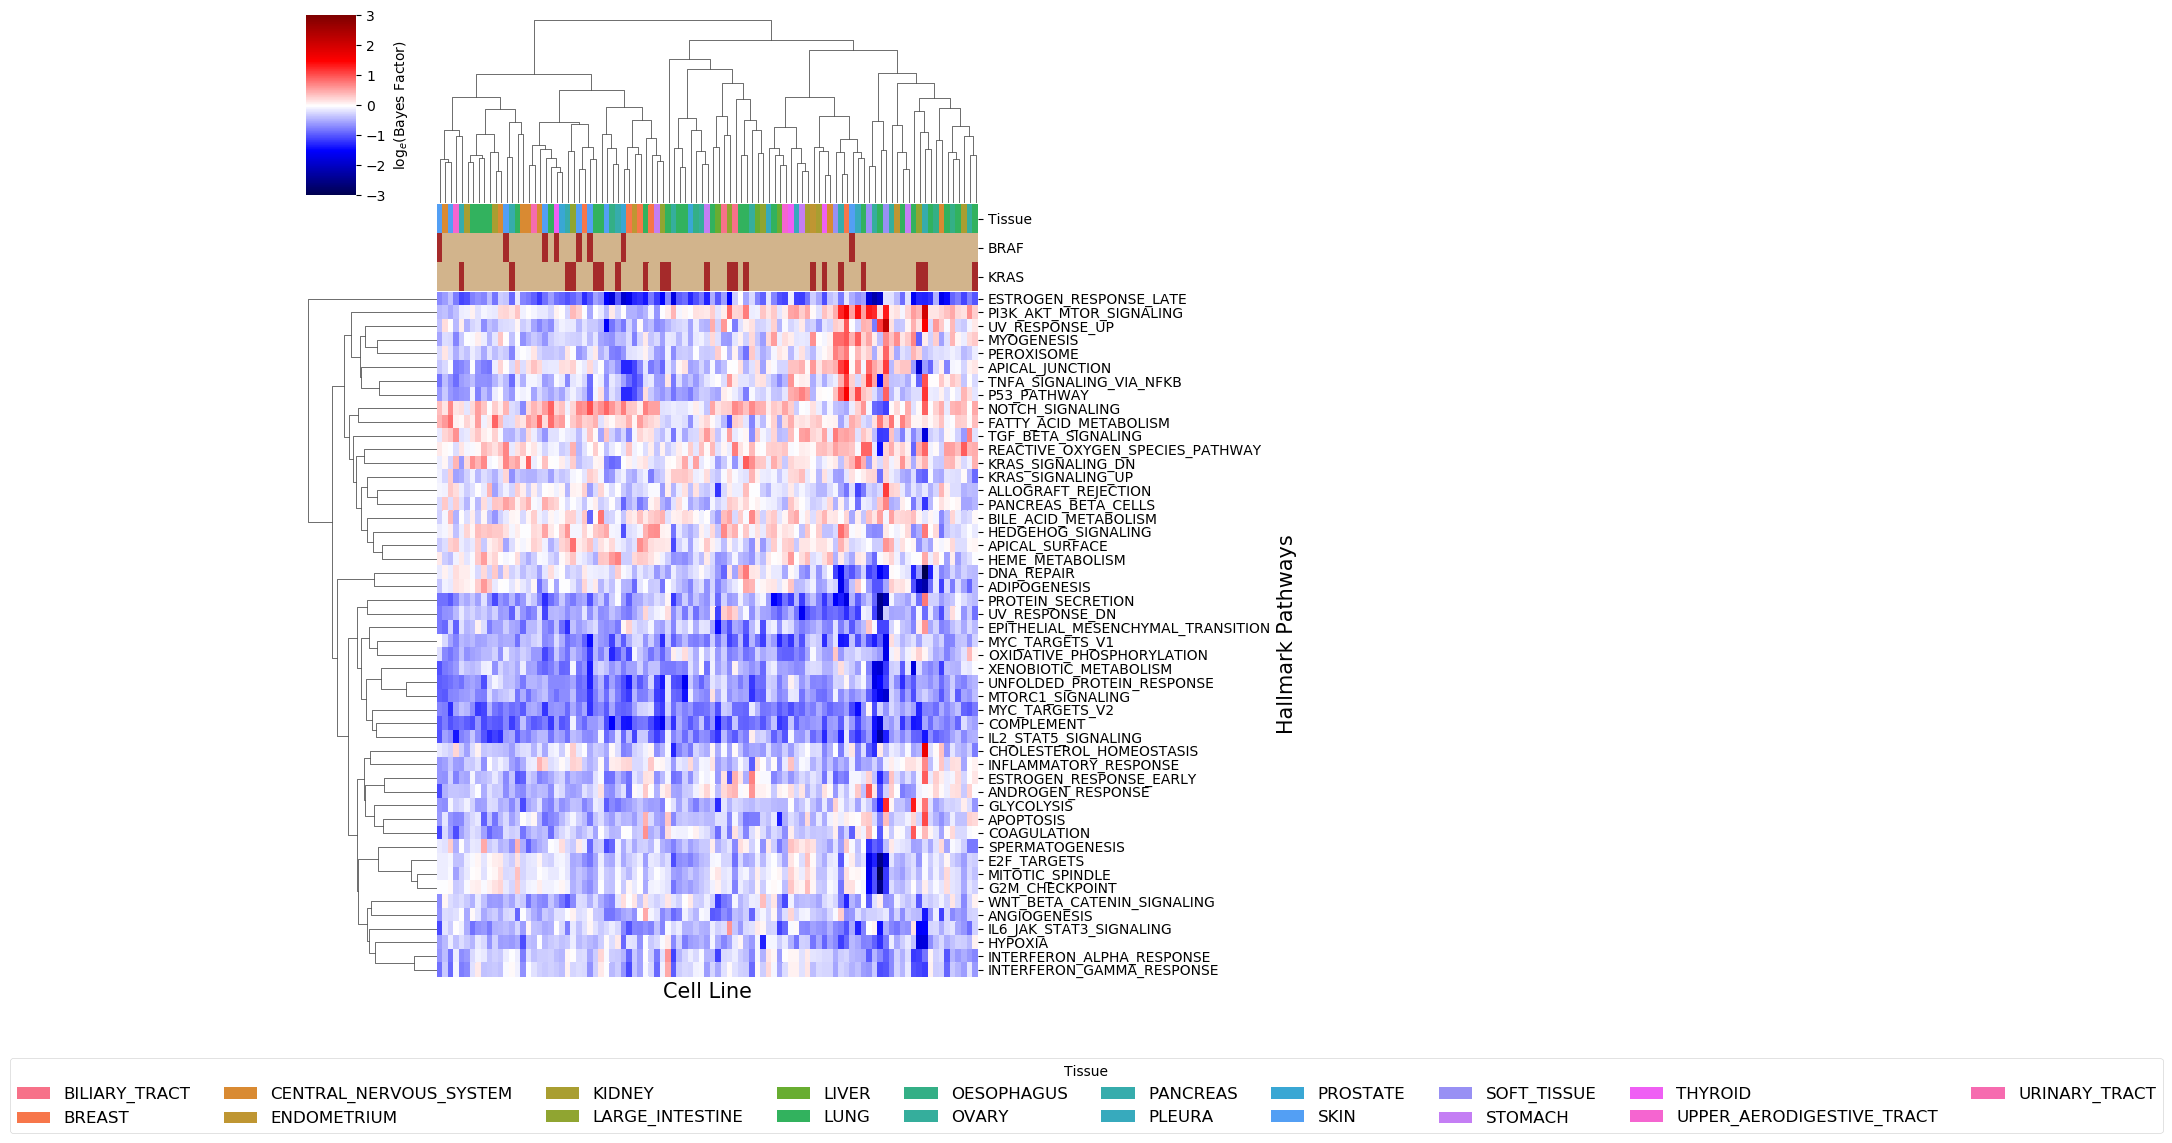

In [55]:
# Reload if necessary
heatmap_df = df_res_all
drug_list = ['Trametinib', 'Dabrafenib', 'Navitoclax', 'BRD3379']

tissue_lbl = np.array(['_'.join(f.split('/')[0].split('_')[1:]) for f in list(heatmap_df)])
lut3 = dict(zip(np.unique(tissue_lbl), sns.color_palette("husl", len(set(tissue_lbl)))))
tissue_colors = [lut3['_'.join(k.split('/')[0].split('_')[1:])] for k in list(heatmap_df)]

braf_mut = cl_feat[cl_feat['in_pool']][['BRAF_MUT','CCLE_ID']]
dict_braf_mut = dict(zip(braf_mut['CCLE_ID'], braf_mut['BRAF_MUT']))
braf_colors = ['tan' if dict_braf_mut[c]==0. else 'brown' for c in cell_lbl]

kras_mut = cl_feat[cl_feat['in_pool']][['KRAS_MUT','CCLE_ID']]
dict_kras_mut = dict(zip(braf_mut['CCLE_ID'], kras_mut['KRAS_MUT']))
kras_colors = ['tan' if dict_kras_mut[c]==0. else 'brown' for c in cell_lbl]

hras_mut = cl_feat[cl_feat['in_pool']][['HRAS_MUT','CCLE_ID']]
dict_hras_mut = dict(zip(hras_mut['CCLE_ID'], hras_mut['HRAS_MUT']))
hras_colors = ['tan' if dict_hras_mut[c]==0. else 'brown' for c in cell_lbl]

all_annot_colors = pd.DataFrame({'Tissue':tissue_colors,
                                 'BRAF':braf_colors,
                                 'KRAS':kras_colors})
all_annot_colors.index = list(heatmap_df)

for drug in drug_list:
    print('==== DRUG:%s ==='%(drug))
    sub_col = [c for c in list(heatmap_df) if drug in c]
    sub_df = heatmap_df[sub_col]
    plt.figure(figsize=[10,5])
    d = sch.distance.pdist(sub_df.T, metric='correlation')
    L = sch.linkage(d, method='complete')
    cg = sns.clustermap(sub_df, cmap='seismic', col_linkage=L, center=0, vmin=-3, vmax=3, col_colors=all_annot_colors,
                       linewidths=0, xticklabels=False, yticklabels=True,
                       cbar_kws={'label': r'$\log_e$(Bayes Factor)'})
    for label in np.unique(tissue_lbl):
        cg.ax_row_dendrogram.bar(0, 0, color=lut3[label], label=label, linewidth=0)

    l2 = cg.ax_row_dendrogram.legend(title='Tissue', loc="center", ncol=10, bbox_to_anchor=(0.8,-0.1),
                                     bbox_transform=plt.gcf().transFigure, fontsize=12)
    ax = cg.ax_heatmap
    ax.set_xlabel('Cell Line', fontsize=15)
    ax.set_ylabel('Hallmark Pathways', fontsize=15)
    plt.savefig(path_to_save+'hm_'+drug+'_-tissue-mut-withleg.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [56]:
# Save for later
df_res_all.to_csv('../paper/mixseq_cl_bf.csv', sep=',', index=True, header=True)